Due to 20/01/2025

The objective is to predict the energy consumption in the Wastewater Treatment Plant (WWTP)

**Libraries**

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split

**Data import**

In [20]:
df = pd.read_csv('data-melbourne.csv')

In [21]:
df = df.drop(['VG','TM', 'Tm', 'VM'], axis=1)

In [22]:
df_normalised = df.copy()
df_normalised = df_normalised.drop(['year', 'month', 'day'], axis=1)

**Pre-processing**

In [23]:
columns_to_plot = ['avg_outflow','avg_inflow','total_grid','Am','BOD','COD','TN','T','SLP','H','PP','VV','V']

means = df[columns_to_plot].mean()
stds = df[columns_to_plot].std()

df_normalised[columns_to_plot] = (df[columns_to_plot] - means) / stds

In [24]:
df_normalised.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,SLP,H,PP,VV,V
0,-0.805359,-1.331870,-2.224505,-1.574715,-0.198401,-0.797436,-0.661643,0.789723,-0.060236,-0.520057,0.996165,0.05504,1.039293
1,-0.809428,-1.073462,-2.095295,-1.832394,-0.140259,-0.728668,-0.760214,0.382202,-0.060236,-0.038434,-0.166873,0.05504,-0.712176
2,-0.815939,-0.890076,-1.638490,0.357877,0.417906,-0.068496,0.498805,0.326631,-0.060236,-1.139286,0.024416,0.05504,1.739880
3,-0.815939,-0.800466,-1.514590,-0.415160,0.557448,0.027779,0.072597,-0.080890,-0.060236,-1.001679,-0.166873,0.05504,1.053304
4,-0.824891,-0.494822,-1.620390,0.873235,1.464467,1.169328,0.797877,-0.303175,-0.060236,0.099172,-0.166873,0.05504,0.156552


##### **Model accuracy metrics**

**Residual Sum of Squares**

In [25]:
def calc_rss(y, y_pred):
    rss = sum((y - y_pred)**2)
    
    return rss

**Total Sum of Squares**

In [26]:
def calc_tss(y):
    n = len(y)
    y_avg = sum(y)/n
    tss = sum((y - y_avg)**2)

    return tss

**Root Mean Squared Error**

In [27]:
def calc_rmse(y, y_pred):
    n = len(y)
    mse = (sum((y - y_pred)**2))/n
    rmse = mse**(1/2)
    
    return rmse

$\mathbf{R^2}$

In [28]:
def calc_r2(y, y_pred):
    rss = calc_rss(y, y_pred)
    tss = calc_tss(y)
    r2 = 1 - (rss/tss)

    return r2

##### **Train and test datasets**

In [29]:
X = df_normalised.copy()
X = X.drop(['total_grid'], axis=1)

y = df_normalised['total_grid']

In [30]:
X.insert(0, 'intercept', 1)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

### **Task 1 - Ordinary Linear Square (OLS) Regression**

$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p + \epsilon$

$\hat{y} = \hat{\beta_0} + \hat{\beta_1} x_1 + \hat{\beta_2} x_2 + \cdots + \hat{\beta_p} x_p$

$RSS = \displaystyle \sum_{i=1}^n (y_i - \hat{y_i})^2 = \sum_{i=1}^{n}(y_1 - \hat{\beta_0} - \hat{\beta_1}x_{i1} - \hat{\beta_2}x_{i2} - \cdots - \hat{\beta_p}x_{ip})^2$

$\hat{\beta} = (\mathbf{X}^T X)^{-1} \mathbf{X}^T y$

#### **From scratch**

In [32]:
def ica_linear_regression(X_train, y_train, X_test, y_test):
    X_T = X_train.T
    B = np.linalg.inv(X_T @ X_train) @ X_T @ y_train

    y_pred = np.dot(X_test, B)

    RMSE = calc_rmse(y_test, y_pred)
    R2 = calc_r2(y_test, y_pred)

    return RMSE, R2

In [33]:
def ica_ridge_regression(L, X_train, y_train, X_test, y_test):
    I = np.identity(X_train.shape[1])

    X_T = X_train.T
    B_ridge = np.linalg.inv(L*I + X_T @ X_train) @ X_T @ y_train

    y_pred_ridge = np.dot(X_test, B_ridge)

    RMSE = calc_rmse(y_test, y_pred_ridge)
    R2 = calc_r2(y_test, y_pred_ridge)
    

    return RMSE, R2

In [37]:
def ica_kfold_cross_validation(k, X_train, y_train, model, *L):
    n_train = len(X_train)
    fold_length = round(n_train/k)

    indices = np.array(X_train.index)

    k_rmse = np.zeros(k)
    k_r2 = np.zeros(k)

    for fold in range(k):
        start_idx = fold* fold_length
        end_idx = (fold + 1) * fold_length

        validation_indices = indices[start_idx:end_idx]

        train_indices = np.setdiff1d(indices, validation_indices)

        X_train_fold = X_train.loc[train_indices]
        X_val_fold = X_train.loc[validation_indices]

        y_train_fold = y_train.loc[train_indices]
        y_val_fold = y_train.loc[validation_indices]

        if model=='linear_regression':

            rmse, r2 = ica_linear_regression(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        elif model=='ridge_regression':
            rmse, r2 = ica_ridge_regression(L, X_train_fold, y_train_fold, X_val_fold, y_val_fold)

        # print(str(fold+1)+": RMSE = " + str(rmse) + " R2 = " + str(r2))
        k_rmse[fold] = rmse
        k_r2[fold] = rmse

    return k_rmse, k_r2

##### **No Cross-Validation**

In [35]:
rmse, r2 = ica_linear_regression(X_train, y_train, X_test, y_test)
print(rmse, r2)

0.9336351884589535 0.18855335046047272


##### **5-fold Cross-validation**

In [38]:
[rmse, r2] = ica_kfold_cross_validation(5, X_train, y_train, 'linear_regression')

In [39]:
rmse

array([1.00229634, 0.90955571, 0.98310124, 0.84422018, 0.93896511])

In [40]:
k = 10
n_train = len(X_train)
fold_length = round(n_train/k)

indices = np.array(X_train.index)

In [41]:
mse = 0

for fold in range(k):
    start_idx = fold* fold_length
    end_idx = (fold + 1) * fold_length

    validation_indices = indices[start_idx:end_idx]

    train_indices = np.setdiff1d(indices, validation_indices)

    X_train_fold = X_train.loc[train_indices]
    X_val_fold = X_train.loc[validation_indices]

    y_train_fold = y_train.loc[train_indices]
    y_val_fold = y_train.loc[validation_indices]

    rmse, r2 = ica_linear_regression(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    mse = mse + rmse**(1/2)

    print(str(fold+1)+": RMSE = " + str(rmse) + " R2 = " + str(r2))

CVk = mse/k

print('CV'+str(k)+'='+str(CVk))

1: RMSE = 0.9901743769896688 R2 = 0.10392762829886826
2: RMSE = 1.003746810611941 R2 = 0.06926612047053815
3: RMSE = 0.995533188072315 R2 = -0.0474910390057508
4: RMSE = 0.816358228445119 R2 = 0.18729686406020973
5: RMSE = 1.0685705743466247 R2 = -0.01826629868179097
6: RMSE = 0.890844963438425 R2 = 0.14961962883384405
7: RMSE = 0.8780983645214064 R2 = 0.18853296543875664
8: RMSE = 0.847641175334564 R2 = -0.0063802934513534915
9: RMSE = 0.8102404014451663 R2 = 0.18374511723713205
10: RMSE = 1.0123265909703858 R2 = 0.15061362529305045
CV10=0.9639820261884274


#### **From libraries**

##### **No Cross-validation**

In [42]:
import statsmodels.api as sm

In [43]:
model1 = sm.OLS(y, X)
results1 = model1.fit()

In [44]:
r_squared = results1.rsquared
print(r_squared)

0.1457347174635768


##### **5-Fold Cross Validation**

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [46]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.0803197 , 0.07773138, 0.05651731, 0.13302242, 0.14036073])

##### **10-Fold Cross-Validation**

In [47]:
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=10)
scores

array([ 0.10392763,  0.06926612, -0.04749104,  0.18729686, -0.0182663 ,
        0.14961963,  0.18673633,  0.0300599 ,  0.12699538,  0.15005973])

### **Task 2: Penalised Linear Regression**

#### **From scratch**

##### **Ridge Regression ($l_2$ penalty)**

*(James, Gareth, et al. 2013)* The Ridge Regression coefficients estimates $\hat{\beta}^R$ are the values that minimize

$\displaystyle \sum_{i=1}^n \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2 = RSS + \lambda \sum_{j=1}^p \beta_j^2$

*(Hastie et al. 2017)* The closed form of the Ridge Regression is given by

$\hat{\mathbf{\beta}}^{ridge} = (\mathbf{X^T \mathbf{X}} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$

In [48]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    RMSE, R2 = ica_ridge_regression(l, X_train, y_train, X_test, y_test)
    rmse_L[i] = RMSE
    r2_L[i] = R2

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_15380\3390629931.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

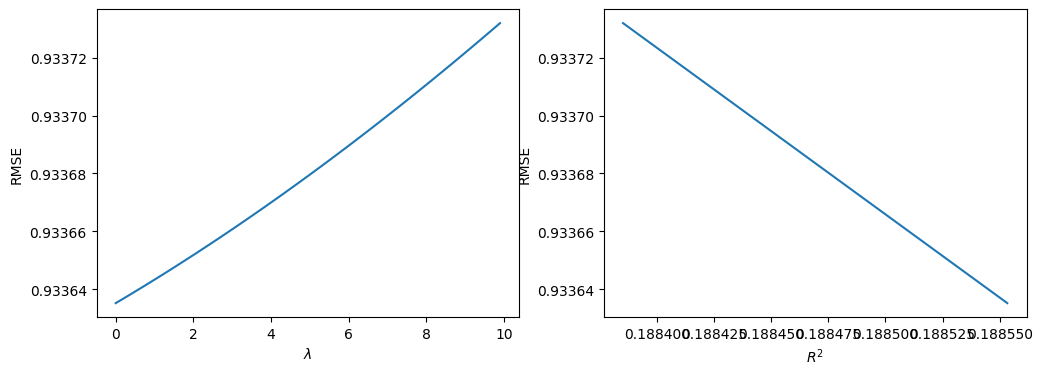

In [49]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')


##### **5-fold Cross Validation**

In [50]:
L = np.arange(0,100,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_15380\3722744685.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


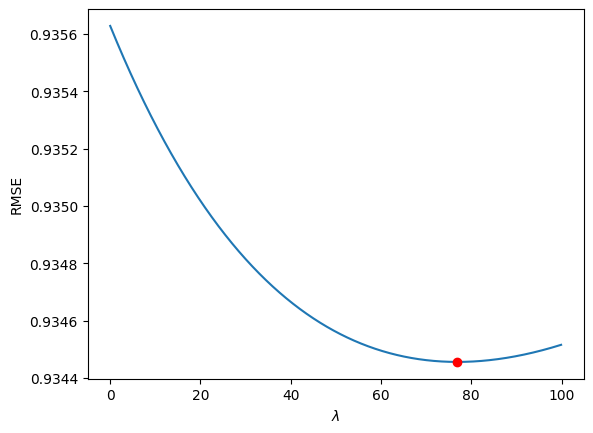

In [51]:
plt.plot(L, rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, rmse_min_k5, color='red', zorder=2)

##### **10-Fold Cross-Validation**

In [52]:
L = np.arange(0,100,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]
    rmse, r2 = ica_kfold_cross_validation(k, X_train, y_train, 'ridge_regression', l)
    rmse_L_k10[i] = sum(rmse)/k

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_15380\3245871270.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


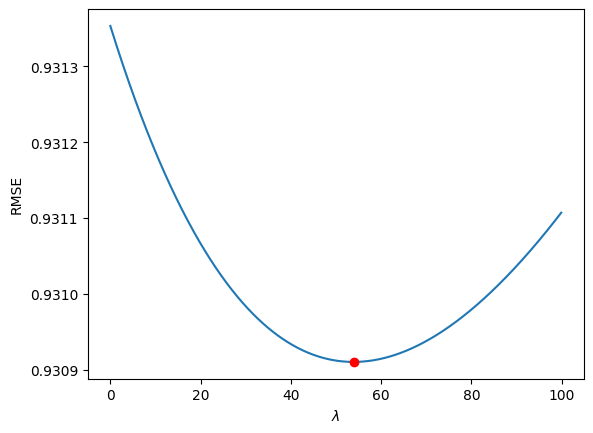

In [53]:
plt.plot(L, rmse_L_k10, zorder=1)

min_index = np.argmin(rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, rmse_min_k10, color='red', zorder=2)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

plt.show()

##### **Lasso Regression ($l_1$ penalty)**

(Jamie et al. 2013) The lasso coefficients $\beta_{\lambda}^L$, minimize the quantity

$\displaystyle \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^p |\beta_j| = RSS + \lambda \sum_{j=1}^p |\beta_j|$

(Hastie et al. 2017) We can write the residual sum of squares as

$RSS(\beta) = (\mathbf{y} - \mathbf{X}\beta)^T(\mathbf{y} - \mathbf{X}\beta)$

Differentiating with respect to $\beta$ we obtain

$\cfrac{\partial RSS}{\partial \beta} = -2\mathbf{X}^T(\mathbf{y} - \mathbf{X}\beta)$

For the absolute value function $f(\beta) = |\beta|$, we have

$\partial f(\beta) =
\begin{cases}
{+1} & \text{if} \beta > 0\\
{-1} & \text{if} \beta < 0\\
[-1,+1] & \text{if} \beta = 0.
\end{cases}$

In [68]:
def gradient_descent_lasso(num_iterations, N, L, X_train, y_train):
    for i in range(num_iterations):
        n = X_train.shape[1]
        B = np.zeros(n)
        y_pred = X_train.dot(B)
        dB = np.zeros(n)
        for j in range(n):
            if B[j] > 0:
                dB[j] = -2*(X[:,j].dot(y_train - y_test))

    return B

In [66]:
num_iterations = 1000
N = 0.01
L = 1
B0 = np.ones(X_train.shape[1])

In [54]:
from scipy.optimize import minimize

In [60]:
def lasso_regression(B, X_train, y_train, L):
    rss = np.sum((y_train - (B[0] + np.dot(X_train, B[1:]))) ** 2)
    l1_penalty = L * np.sum(np.abs(B[1:]))

    total_loss = rss + l1_penalty
    return total_loss

In [62]:
x0 = np.ones(X_train.shape[1] + 1)
res = minimize(lasso_regression, x0, method='nelder-mead', args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':True})

C:\Users\room2\AppData\Local\Temp\ipykernel_15380\3140004214.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(lasso_regression, x0, method='nelder-mead', args=(X_train, y_train, 1), options={'xatol': 1e-8, 'disp':True})


#### **From libraries**

##### **Ridge Regression ($l_2$ penalty)**

In [321]:
from sklearn.linear_model import Ridge

In [323]:
ridgereg = Ridge(alpha=1.0)
ridgereg.fit(X_train, y_train)
y_pred_ridge = ridgereg.predict(X_test)


In [326]:
calc_rmse(y_test, y_pred_ridge)
calc_r2(y_test, y_pred_ridge)

0.1885384276639649

In [331]:
L = np.arange(0,10,0.1)
rmse_L = np.zeros(len(L))
r2_L = np.zeros(len(L))

for i in range(0,len(L)):
    l = L[i]
    
    ridgereg = Ridge(alpha=l)
    ridgereg.fit(X_train, y_train)
    y_pred_ridge = ridgereg.predict(X_test)
    
    rmse_L[i] = calc_rmse(y_test, y_pred_ridge)
    r2_L[i] = calc_r2(y_test, y_pred_ridge)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_14236\1516381242.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('$\lambda$')


Text(0, 0.5, 'RMSE')

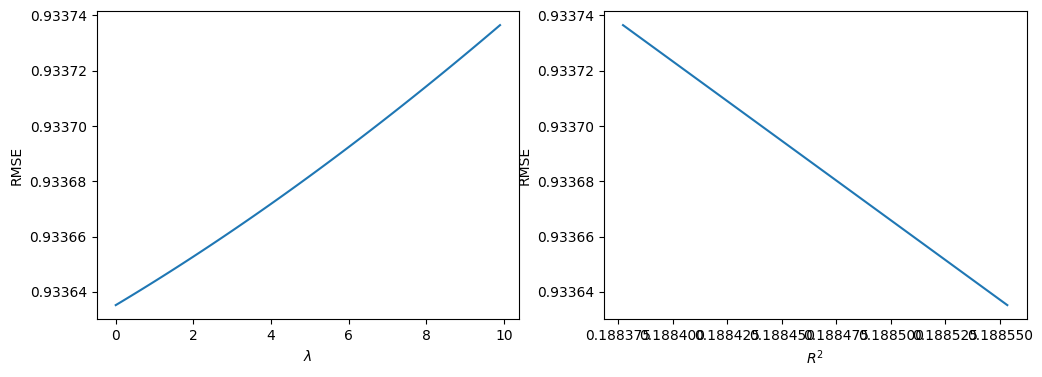

In [332]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.plot(L, rmse_L)
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('RMSE')

ax2.plot(r2_L, rmse_L)
ax2.set_xlabel('$R^2$')
ax2.set_ylabel('RMSE')

##### **5-Fold Cross-Validation**

In [354]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 5

rmse_L_k5 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=k)
    rmse_L_k5[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_14236\2351975880.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


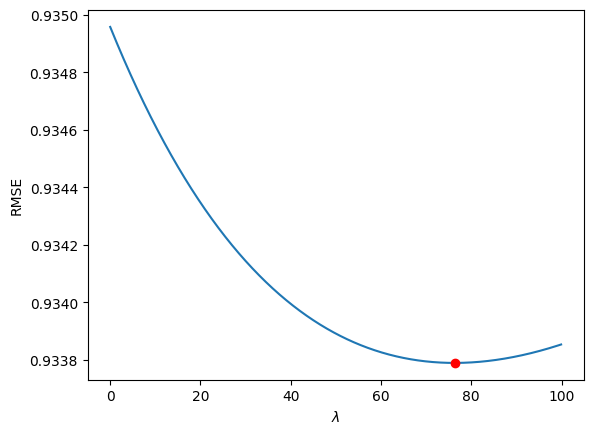

In [355]:
plt.plot(L, -rmse_L_k5, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k5)
lambda_min_k5 = L[min_index]
rmse_min_k5 = rmse_L_k5[min_index]

plt.scatter(lambda_min_k5, -rmse_min_k5, color='red', zorder=2)

##### **10-Fold Cross-Validation**

In [352]:
lm = LinearRegression()

L = np.arange(0,100,0.1)
k = 10

rmse_L_k10 = np.zeros((len(L)))

for i in range(0,len(L)):
    l = L[i]

    ridgereg = Ridge(alpha=l)

    rmse = cross_val_score(ridgereg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    rmse_L_k10[i] = sum(rmse)/k

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\room2\AppData\Local\Temp\ipykernel_14236\1264941061.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$')


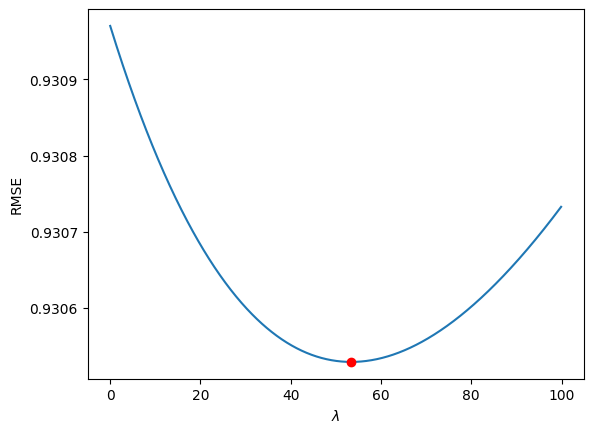

In [353]:
plt.plot(L, -rmse_L_k10, zorder=1)
plt.xlabel('$\lambda$')
plt.ylabel('RMSE')

min_index = np.argmin(-rmse_L_k10)
lambda_min_k10 = L[min_index]
rmse_min_k10 = rmse_L_k10[min_index]

plt.scatter(lambda_min_k10, -rmse_min_k10, color='red', zorder=2)

##### **Lasso Regression ($l_2$ penalty)**

### **Task 3: PCR and PLS Regression**

### **Task 4: Neural Network for Regression**

##### **References**

James, Gareth, et al. *An introduction to statistical learning*. Vol. 112. New York: springer, 2013.

Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. *The elements of statistical learning: data mining, inference, and prediction*. (2017).

Hastie, Trevor, Robert Tibshirani, and Martin Wainwright. "Statistical learning with sparsity." Monographs on statistics and applied probability 143.143 (2015): 8.